In [1]:
import numpy as np
import pandas as pd
import torch
from model import EEGNet, EEGDataset, create_dataloaders, train_model, plot_metrics, save_training_stats
from explore import apply_bandpass_filter
from load_data import get_dataset
from feature_extraction import extract_all_features_per_trial

In [2]:
train_df = get_dataset("data/SMNI_CMI_TRAIN/Train/")
test_df = get_dataset("data/SMNI_CMI_TEST/Test/")

dataset loaded from tmp/dea5a0ab2c.pickle
dataset loaded from tmp/0d05880708.pickle


In [3]:
df = pd.concat([train_df, test_df], ignore_index=True)

filtered_df = df.groupby(['name', 'trial number', 'sensor position']) \
               .apply(apply_bandpass_filter) \
               .reset_index(drop=True)

In [4]:
print(filtered_df.shape)
print(filtered_df.head())

(15532032, 10)
   trial number sensor position  sample num  sensor value subject identifier  \
0             0             AF1           0        -2.146                  a   
1             0             AF1           1        -2.146                  a   
2             0             AF1           2        -1.658                  a   
3             0             AF1           3        -0.682                  a   
4             0             AF1           4         2.248                  a   

  matching condition  channel         name      time  filtered_sensor_value  
0             S1 obj        4  co2a0000364  0.000000              -0.004665  
1             S1 obj        4  co2a0000364  0.003906              -0.040292  
2             S1 obj        4  co2a0000364  0.007812              -0.165046  
3             S1 obj        4  co2a0000364  0.011719              -0.429810  
4             S1 obj        4  co2a0000364  0.015625              -0.797100  


In [5]:
def extract_eeg_sequences(df: pd.DataFrame, group_label: int):
    eeg_segments = []
    labels = []
    grouped = df.groupby(['name', 'trial number'])

    for (name, trial), group in grouped:
        pivot = group.pivot_table(
            index='sensor position',
            columns='time',
            values='filtered_sensor_value'
        )

        eeg_segments.append(pivot.values)
        labels.append(group_label)
    return np.stack(eeg_segments), np.array(labels)

alcohol_df = filtered_df[filtered_df['subject identifier'] == 'a']
control_df = filtered_df[filtered_df['subject identifier'] == 'c']

X_a, y_a = extract_eeg_sequences(alcohol_df, group_label=0)
X_c, y_c = extract_eeg_sequences(control_df, group_label=1)

X_full = np.concatenate([X_a, X_c], axis=0)
y_full = np.concatenate([y_a, y_c], axis=0)

In [6]:
print(X_full.shape) #924 measurements, 64 sensors, 256 time points

(924, 64, 256)


In [7]:
print(y_full.shape)

(924,)


In [8]:
train_loader, val_loader = create_dataloaders(X_full, y_full, batch_size=32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EEGNet(num_channels=64, num_time_points=256, num_classes=2)
print("Model Summary:")
print(model)

Model Summary:
EEGNet(
  (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): Conv2d(8, 16, kernel_size=(64, 1), stride=(1, 1), groups=8, bias=False)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ELU(alpha=1.0)
  (avgpool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (dropout1): Dropout(p=0.5, inplace=False)
  (separable_conv): Sequential(
    (0): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
    (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): ELU(alpha=1.0)
  (avgpool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
  (dropout2): Dropout(p=0.5, inplace=False)
  (classifier): Linear(in_features=128, out

In [9]:
sample_X, _ = next(iter(train_loader))
print(sample_X.shape) 

torch.Size([32, 1, 64, 256])


In [ ]:
best_model, stats = train_model(
    EEGNet,
    train_loader,
    val_loader,
    epochs=100,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=12,      # stop after 12 non-improving epochs
    min_delta=0.001,  # require at least 0.001 drop in val-loss
)
torch.save(model.state_dict(), "models/signal_only_model.pt")

Epoch 1/20 | Train Loss: 0.6272 | Val Loss: 0.5823 | Val Acc: 0.6865
Epoch 2/20 | Train Loss: 0.5395 | Val Loss: 0.5201 | Val Acc: 0.7297
Epoch 3/20 | Train Loss: 0.5124 | Val Loss: 0.4687 | Val Acc: 0.7784
Epoch 4/20 | Train Loss: 0.4594 | Val Loss: 0.4255 | Val Acc: 0.8162
Epoch 5/20 | Train Loss: 0.3950 | Val Loss: 0.3942 | Val Acc: 0.8270
Epoch 6/20 | Train Loss: 0.3629 | Val Loss: 0.3366 | Val Acc: 0.8595
Epoch 7/20 | Train Loss: 0.3200 | Val Loss: 0.2851 | Val Acc: 0.9027
Epoch 8/20 | Train Loss: 0.3074 | Val Loss: 0.2858 | Val Acc: 0.8541
Epoch 9/20 | Train Loss: 0.2645 | Val Loss: 0.2189 | Val Acc: 0.9297
Epoch 10/20 | Train Loss: 0.2395 | Val Loss: 0.1814 | Val Acc: 0.9351
Epoch 11/20 | Train Loss: 0.2139 | Val Loss: 0.1501 | Val Acc: 0.9514
Epoch 12/20 | Train Loss: 0.1846 | Val Loss: 0.1337 | Val Acc: 0.9568
Epoch 13/20 | Train Loss: 0.1416 | Val Loss: 0.1029 | Val Acc: 0.9622
Epoch 14/20 | Train Loss: 0.1196 | Val Loss: 0.0838 | Val Acc: 0.9676
Epoch 15/20 | Train Loss: 0.1

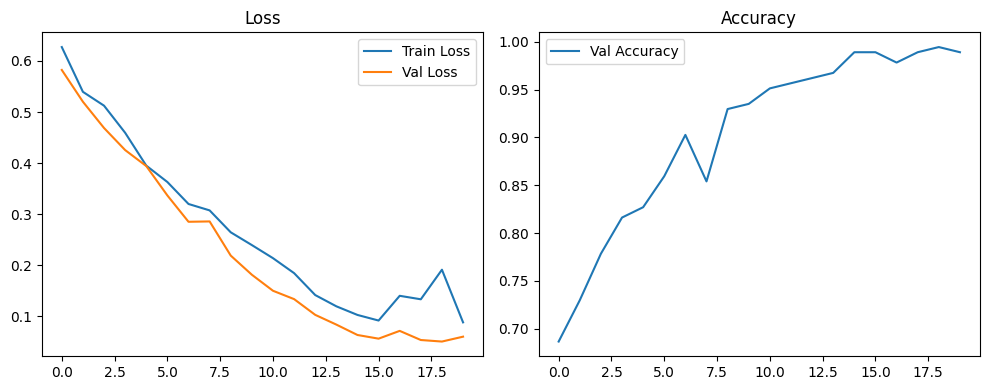

In [11]:
plot_metrics(stats)
save_training_stats(stats, "training_stats.csv")

In [12]:
from torch.utils.data import DataLoader

def evaluate_on_full_data(model, X, y, batch_size=32, device='cpu'):
    model.eval()
    dataset = EEGDataset(X, y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            pred = output.argmax(dim=1)
            correct += pred.eq(y_batch).sum().item()

    return correct / len(dataset)

acc = evaluate_on_full_data(model, X_full, y_full, device=device)
print(f"Accuracy on all data: {acc:.4f}")

Accuracy on all data: 0.9935
